In [444]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse
import random

from collections import Counter


from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# 1 Import Dataset

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

Binarize the Data

In [5]:
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

---
---

# 2 Un-Collapsed Gibbs Sampling

## 2.1 Algorithm

Joint Posterior 

$$\begin{align}
    p(\boldsymbol{\pi},\boldsymbol{\theta},\mathbf{z}|\mathbf{X},\boldsymbol{\alpha},a,b) \propto p(\mathbf{X}|\mathbf{z},\boldsymbol{\theta}) p(\mathbf{z}|\boldsymbol{\pi}) p(\boldsymbol{\pi}|\boldsymbol{\alpha}) p(\boldsymbol{\theta}|a,b)
\end{align}$$

Routine

1) Initialize 
$$\begin{align}
    \boldsymbol{\alpha} &= [\alpha_1 = \frac{1}{K},...,\alpha_K = \frac{1}{K}]\\
    a,b &= \frac{1}{2}\\
    \boldsymbol{\pi} &\sim \mathcal{Dirichlet}(\boldsymbol{\alpha})\\
    \boldsymbol{\theta} &\sim \mathcal{Beta}(a,b)\\
    \boldsymbol{z} &\sim \mathcal{Cat}(\boldsymbol{\pi})
\end{align}$$




2) For $t=1,..,N$
$$\begin{align}
    \text{Sample } \boldsymbol{\pi}^{(t)} &\sim \mathrm{Dirichlet}(\boldsymbol{\alpha}_N) \\
        \boldsymbol{\alpha}_N &= \left[\alpha_0^1 + n_1,\, \alpha_0^2 + n_2,\, \dots,\, \alpha_0^K + n_K \right],
        \quad \text{where} \quad
        n_k = \sum_{i=1}^N \mathbb{1}(z_i^{(t-1)} = k) \\\\

    \text{Sample } \boldsymbol{\theta}^{(t)} &\sim \mathrm{Beta}(\mathbf{a}_N, \mathbf{b}_N) \\
        \mathbf{a}_N &= \left[
        \begin{matrix}
        a_{0,1} + n_{1,1}^{(1)} & \cdots & a_{0,D} + n_{1,D}^{(1)} \\
        \vdots & \ddots & \vdots \\
        a_{K,1} + n_{K,1}^{(1)} & \cdots & a_{K,D} + n_{K,D}^{(1)}
        \end{matrix}
        \right],
        \quad \text{where} \quad
        n_{k,d}^{(1)} = \sum_{i=1}^N \mathbb{1}(x_{i,d} = 1 \land z_i^{(t-1)} = k) \\\\

        \mathbf{b}_N &= \left[
        \begin{matrix}
        b_{0,1} + n_{1,1}^{(0)} & \cdots & b_{0,D} + n_{1,D}^{(0)} \\
        \vdots & \ddots & \vdots \\
        b_{K,1} + n_{K,1}^{(0)} & \cdots & b_{K,D} + n_{K,D}^{(0)}
        \end{matrix}
        \right],
        \quad \text{where} \quad
        n_{k,d}^{(0)} = \sum_{i=1}^N \mathbb{1}(x_{i,d} = 0 \land z_i^{(t-1)} = k)\\\\

    \text{Sample } \mathbf{z}^{(t)} &= [z_1^{(t)}, \dots, z_N^{(t)}] \quad \text{where,}\\

        &\boldsymbol{z}_i^{(t)} \sim \text{Categorical}(p_1^{(i)},...,p_K^{(i)}) \quad \text{where,}\\
        &\qquad p_k^{(i)} \propto \pi_k^{(t)} \prod_{d=1}^D (\theta_{k,d}^{(t)})^{x_{i,d}}(1-\theta_{k,d}^{(t)})^{(1 - x_{i,d})}
\end{align}$$

---

Softmax:

$$
    \mathbf{softmax}_i(p_k) = \frac{\exp(p_{ik}) - \exp(\mathbf{max}(\mathbf{p}_i))}{\sum_{k'}\exp(p_{ik'})}
$$

In [353]:
def sampleZs(X, θ, π, eps):
    ''' 
        Compute softmax to produce cat distribution for each row

        @param (X) : data matrix (n x d)
        @param (θ) : biases for each pixel (K x d)
        @param (π) : mixture weights for each component (K)
    '''

    # Compute Categorical Distribution over components for each row using SoftMax
    logp  = np.log(π + eps) + (X @ np.log(θ + eps).T + (1 - X) @ np.log(1 - θ + eps).T) # log likelihood
    logp -= logp.max(axis=1, keepdims=True) # reduce logits for numerical stability (invariance property)
    p     = np.exp(logp)
    p    /= p.sum(axis=1, keepdims=True) # normalize

    # Inverse Sample from Categorical Distribution
    cdf = np.cumsum(p, axis=1) # compute CDF for each row (each categorical distribution)
    u   = rng.random(size=(p.shape[0], 1))
    return (cdf > u).argmax(axis=1)  # return first index where cdf is greater than random u

In [8]:
def sample_θ(X, zs, a_mat, b_mat, K) :
    ''' 
        Samples θs from multivariate Beta distribution

        @param (X)     : data matrix (nxd)
        @param (zs)    : component assignments (n)
        @param (a_mat) : multi-var beta prior for a (K, d)
        @param (b_mat) : multi-var beta prior for b (K, d)
        @param (K)     : the number of components
    '''

    n,d=X.shape

    nkd1 = np.zeros((K,d))
    nkd0 = np.zeros((K,d))

    for k in range(K):
        indices = np.where(zs == k)[0].tolist()
        nkd1[k] = X[indices].sum(axis=0)
        nkd0[k] = len(indices) - nkd1[k]
    
    return rng.beta(a_mat + nkd1, b_mat + nkd0)

In [350]:
def sample_π(zs, α_0, K):
    ''' 
        Samples mixing weights from Dirichlet distribution parameterized by pseudocounts of components
        
        @param (zs)  : cluster assignments (n)
        @param (α_0) : Dirichlet prior list (K)
        @param (K)   : the number of components
    '''

    z_counts = np.bincount(zs, minlength=K)
    return rng.dirichlet(α_0 + z_counts)

In [10]:
def gibbs(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape
    X = X.astype(np.uint8)

    πs = np.zeros((num_iter + num_burn, K))
    zs = np.zeros((num_iter + num_burn, n), dtype=np.int16)
    θs = np.zeros((num_iter + num_burn, K, d))

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    πs[0] = rng.dirichlet(α_0)
    R = rng.random((K,d))
    θs[0] = R/np.sum(R, axis=1, keepdims=True)
    zs[0] = sampleZs(X, θs[0], πs[0], eps)

    for t in range(1,num_iter+num_burn):
        πs[t] = sample_π(zs[t-1], α_0, 10)

        θs[t] = sample_θ(X, zs[t-1], a_mat, b_mat, 10)
        
        zs[t] = sampleZs(X, θs[t],πs[t],eps).astype(np.int16)
    
    return πs[num_burn:], θs[num_burn:], zs[num_burn:]

# 2.2 Evaluation

In [11]:
πs,θs,zs= gibbs(X_mnist_train, 1000, 250, 10)

In [12]:
metrics.adjusted_rand_score(Y_mnist_train, zs[-1])

0.3948179243242432

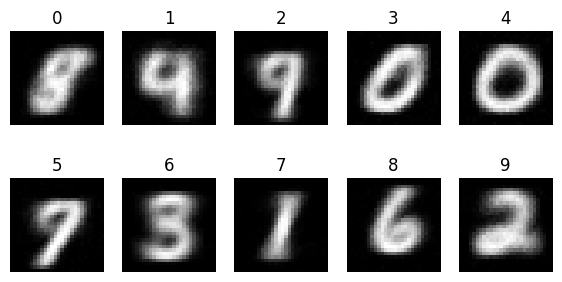

In [13]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = θs[-1][k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

---
---

# 3 Missing Data 

Joint Posterior 

$$\begin{align}
    p(\boldsymbol{\pi},\boldsymbol{\theta},\mathbf{z}, \mathbf{X}_{H}|\mathbf{X}_{O},\boldsymbol{\alpha},a,b) \propto p(\mathbf{X}_{H},\mathbf{X}_{O}|\mathbf{z},\boldsymbol{\theta}) p(\mathbf{z}|\boldsymbol{\pi}) p(\boldsymbol{\pi}|\boldsymbol{\alpha}) p(\boldsymbol{\theta}|a,b)
\end{align}$$

where 
* $\mathbf{X}_H = [\mathbf{x}^{(0)}_H,...,\mathbf{x}^{(N)}_H]$ where $\mathbf{x}^{(i)}_H$ is the hidden part of datapoint $\mathbf{x}^{(i)}$  

* $\mathbf{X}_O = [\mathbf{x}^{(0)}_O,...,\mathbf{x}^{(N)}_O]$ where $\mathbf{x}^{(i)}_O$ is the observable part of datapoint $\mathbf{x}^{(i)}$

So the missing parts become another hidden variable to sample during Gibbs.

#### Basic Routine
$$\begin{align}
    \boldsymbol{\pi} &\sim \mathbf{Dirichlet}(\boldsymbol{\alpha})\\
    \boldsymbol{\theta} &\sim \mathbf{Beta}(a,b)\\
    \mathbf{X}_H &\sim \mathbf{Bernoulli}(\theta)\\
    \mathbf{z} &\sim \mathbf{Cat}(\boldsymbol{\pi})
\end{align}$$

### Gibbs

1) Initialize 

    * $\boldsymbol{\alpha} = [\alpha_1 = \frac{1}{K},...,\alpha_K = \frac{1}{K}]$
    * $a,b = \frac{1}{2}$
    * $\boldsymbol{\pi} \sim \mathbf{Dirichlet}(\boldsymbol{\alpha})$
    * $\boldsymbol{\theta} \sim \mathbf{Beta}(\mathbf{a,b})$
    * For $i\in{1,...,N}$
        * $z_i \sim \mathbf{Categorical}(\boldsymbol{\pi})$
    * For $i\in{1,...,N}$
        * $\mathbf{x}_{i,H} \sim \mathbf{Bernoulli}(\theta_{z_i})$




2) For $t=1,..,N$
$$\begin{align}
    \text{Sample } \boldsymbol{\pi}^{(t)} &\sim \mathrm{Dirichlet}(\boldsymbol{\alpha}_N) \\
        \boldsymbol{\alpha}_N &= \left[\alpha_0^1 + n_1,\, \alpha_0^2 + n_2,\, \dots,\, \alpha_0^K + n_K \right],
        \quad \text{where} \quad
        n_k = \sum_{i=1}^N \mathbb{1}(z_i^{(t-1)} = k) \\\\

    \text{Sample } \boldsymbol{\theta}^{(t)} &\sim \mathrm{Beta}(\mathbf{a}_N, \mathbf{b}_N) \\
        \mathbf{a}_N &= \left[
        \begin{matrix}
        a_{0,1} + n_{1,1}^{(1)} & \cdots & a_{0,D} + n_{1,D}^{(1)} \\
        \vdots & \ddots & \vdots \\
        a_{K,1} + n_{K,1}^{(1)} & \cdots & a_{K,D} + n_{K,D}^{(1)}
        \end{matrix}
        \right],
        \quad \text{where} \quad
        n_{k,d}^{(1)} = \sum_{i=1}^N \mathbb{1}(x_{i,d} = 1, z_i^{(t-1)} = k) \\\\

        \mathbf{b}_N &= \left[
        \begin{matrix}
        b_{0,1} + n_{1,1}^{(0)} & \cdots & b_{0,D} + n_{1,D}^{(0)} \\
        \vdots & \ddots & \vdots \\
        b_{K,1} + n_{K,1}^{(0)} & \cdots & b_{K,D} + n_{K,D}^{(0)}
        \end{matrix}
        \right],
        \quad \text{where} \quad
        n_{k,d}^{(0)} = \sum_{i=1}^N \mathbb{1}(x_{i,d} = 0, z_i^{(t-1)} = k)\\\\

    \text{For } i \in {1,..,N}&\\
        \text{Sample } &z_i^{(t)} \sim \text{Categorical}(p_1^{(i)},...,p_K^{(i)}) \quad \text{where,}\\
            &\qquad p_k^{(i)} \propto \pi_k^{(t)} \prod_{d=1}^D (\theta_{k,d}^{(t)})^{x^{(t-1)}_{i,d}}(1-\theta_{k,d}^{(t)})^{(1 - x^{(t-1)}_{i,d})}

    \text{For } i \in {1,..,N}&\\
        \text{Sample } &\mathbf{x}_{H,i}^{(t)} \sim \mathrm{Bernoulli}(\theta^{(t)}_{z_i^{(t)}})\\ \\

\end{align}$$

3) Discard Burn Samples

In [ ]:
def sample_X_missing(z, θ, X, missing_mask):
    n, D = X.shape
    X_sample = X.copy()

    θ_indexed = θ[z]  # shape (n, D)

    sampled = np.random.binomial(1, θ_indexed)

    X_sample[missing_mask] = sampled[missing_mask]

    return X_sample

In [ ]:
def sample_θ(X, zs, a_mat, b_mat, K, missing_mask) :
    n,D=X.shape
    obs_mask = ~missing_mask

    nkd1 = np.zeros((K,D))
    nkd0 = np.zeros((K,D))

    for k in range(K):
        indices = np.where(zs==k)[0] # (n_k x D)
        obs_k = obs_mask[indices] #filtr observation masks for indices belonging to k (n_k x D)

        nkd1[k] = np.nansum(X[indices] * obs_k, axis=0) # nansum treats nans as 0
        
        obs_counts = np.sum(obs_k, axis=0)# sum all non-nan across D
        nkd0[k] = obs_counts - nkd1[k] 

    return rng.beta(a_mat + nkd1, b_mat + nkd0)

In [ ]:
def gibbs_missing(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape

    missing_mask = np.isnan(X) # (n,d)

    πs = np.zeros((num_iter + num_burn, K))
    zs = np.zeros((num_iter + num_burn, n), dtype=np.int16)
    θs = np.zeros((num_iter + num_burn, K, d))
    Xs = np.zeros((num_iter + num_burn, n, d))

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    πs[0] = rng.dirichlet(α_0)
    R = rng.random((K,d))
    θs[0] = R/np.sum(R, axis=1, keepdims=True)
    zs[0] = np.random.randint(0,K,size=n)
    Xs[0] = sample_X_missing(zs[0],θs[0],X,missing_mask)

    for t in range(1,num_iter+num_burn):
        πs[t] = sample_π(zs[t-1], α_0, 10)

        θs[t] = sample_θ(X, zs[t-1], a_mat, b_mat, 10, missing_mask)
        
        zs[t] = sampleZs(Xs[t-1], θs[t],πs[t],eps).astype(np.int16)

        Xs[t] = sample_X_missing(zs[t],θs[t],X,missing_mask)
    
    return πs[num_burn:], θs[num_burn:], zs[num_burn:], Xs[num_burn:]

## 3.2 Evaluation

### 3.2.1 Half Pixels Randomly Missing

In [223]:
X_mnist_cover1 = np.empty_like(X_mnist_train, dtype='f')
X_mnist_cover1[:] = X_mnist_train
for i in range(0,len(X_mnist_cover1)):
    indices = random.sample(range(0,784), 784//2)
    X_mnist_cover1[i][indices] = np.nan

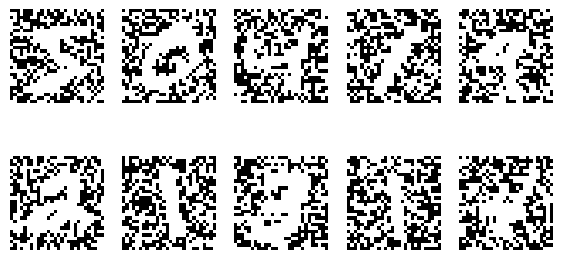

In [224]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = X_mnist_cover1[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [395]:
πs,θs,zs,xs= gibbs_missing(X_mnist_cover1, 400, 100, 10)

In [396]:
metrics.adjusted_rand_score(Y_mnist_train, zs[-1])

0.17828611410452616

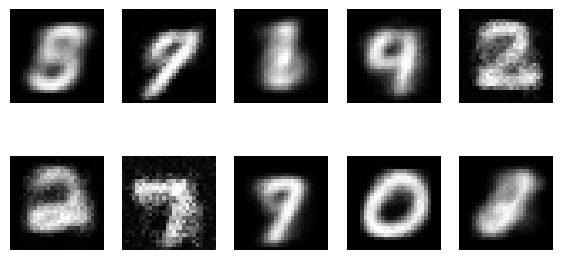

In [397]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = np.mean(θs,axis=0)[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

### 3.2.2 Lower Half of Pixels Missing

In [398]:
X_mnist_cover2 = np.empty_like(X_mnist_train, dtype='f')
X_mnist_cover2[:] = X_mnist_train
X_mnist_cover2[:, 0: int(784//2)] = np.nan

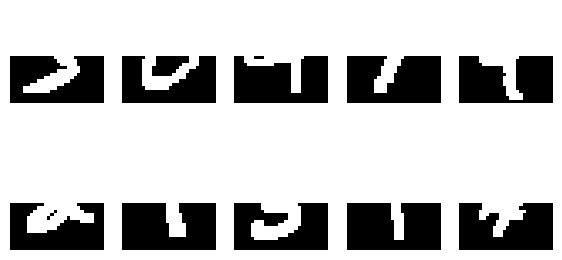

In [399]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = X_mnist_cover2[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [400]:
πs,θs,zs,xs= gibbs_missing(X_mnist_cover1, 400, 100, 10)

In [401]:
metrics.adjusted_rand_score(Y_mnist_train, zs[-1])

0.13998196396581608

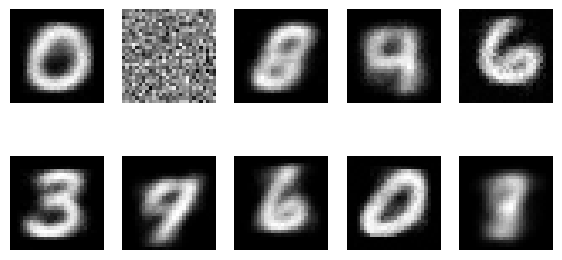

In [402]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = np.mean(θs,axis=0)[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

--- 
---

# 4 Collapsed Gibbs Sampling

Goal is to integrate out $\theta$ and $\pi$ so we can directly just sample $z$ alone.

Full Posterior:
$$
    P(\boldsymbol{\pi},\boldsymbol{\theta},\mathbf{z}|\mathbf{X},\mathbf{a},\mathbf{b},\boldsymbol{\alpha})\propto \underbrace{p(\mathbf{X}|\mathbf{z},\mathbf{\theta}) p(\mathbf{\theta}|a,b)}_{\text{Conjugacy}} \underbrace{p(\mathbf{z}|\mathbf{\pi}) p(\mathbf{\pi}|\mathbf{\alpha})}_{\text{Conjugacy}}
$$

Goal

$$\begin{align}
    P(\mathbf{z}|\mathbf{X}) = \int\int P(\boldsymbol{\pi},\boldsymbol{\theta},\mathbf{z}|\mathbf{X},\mathbf{a},\mathbf{b},\boldsymbol{\alpha})d\mathbf{\theta}d\mathbf{\pi}
\end{align}$$

---

## Beta-Binomial Conjugacy:
$$\begin{align}
    \underset{Binomial}{P(\mathbf{X}|\mathbf{z},\boldsymbol{\theta})}&\underset{Beta}{P(\boldsymbol{\theta}|\mathbf{a},\mathbf{b})} &= 
        \left[ \prod_{i}^{N} \prod_{d}^{D} \theta_{d,z_i}^{x_{d,i}} (1 - \theta_{d,z_i})^{(1 - x_{d,i})} \right]\left[ \prod_{k}^{K} \prod_{d}^{D} \frac{\theta_{d,k}^{(a_{d,k}-1)}(1-\theta_{d,k})^{(b_{d,k} - 1)}}{B(a_{d,k},b_{d,k})} \right]
\end{align}$$

$\quad$ Let $n_{d,k}^{(1)} = \sum_{i}^{N} \mathbb{1}(z_i = k, x_{d,i} = 1)$,  hence $\quad \prod_{i}^{N} \theta_{d,z_i}^{x_{d,i}} = \prod_{k}^{K} \theta_{d,k}^{n_{d,k}^{(1)}}$

$$\begin{align}
     &= \left[ \prod_{k}^{K} \prod_{d}^{D} \theta_{d,k}^{n_{d,k}^{(1)}} (1 - \theta_{d,k})^{n_{d,k}^{(0)}} \right] \left[ \prod_{k}^{K} \prod_{d}^{D} \frac{\theta_{d,k}^{(a_{d,k}-1)}   (1-\theta_{d,k})^{(b_{d,k} - 1)}}{B(a_{d,k},b_{d,k})} \right]\\

    &= \prod_{k}^{K} \prod_{d}^{D} \left(\frac{1}{B(a_{d,k},b_{d,k})} \right) \theta_{d,k}^{(a_{d,k}+n_{d,k}^{(1)}-1)} (1-\theta_{d,k})^{(b_{d,k} + n_{d,k}^{(0)}-1)}
\end{align}$$

$\quad$ Let $\mathbf{a},\mathbf{b},\boldsymbol{\theta},\mathbf{n^{(0)}},\mathbf{n^{(1)}}$ be $(k \times d)$ matrices. E.g.  $B(\mathbf{a},\mathbf{b})=\prod_k^{K}\prod_{d}^{D} B(a_{d,k},b_{d,k})$

$$\begin{align}
    &= \frac{1}{B(\mathbf{a},\mathbf{b})}\boldsymbol{\theta}^{(\mathbf{a} + \mathbf{n}^{(1)}-1)}(1 - \boldsymbol{\theta})^{(\mathbf{b} + \mathbf{n}^{(0)} - 1)}
\end{align}$$

#### Integrate Out $\theta$

$$\begin{align}
    P(\mathbf{X}|\mathbf{z}) &= \int P(\mathbf{X}|\mathbf{z},\boldsymbol{\theta})P(\boldsymbol{\theta}|\mathbf{a},\mathbf{b})d\boldsymbol{\theta}\\\\
                             &= \int \frac{1}{B(\mathbf{a},\mathbf{b})} \boldsymbol{\theta}^{(\mathbf{a} + \mathbf{n}^{(1)} -1)}(1 - \boldsymbol{\theta})^{(\mathbf{b} +    \mathbf{n}^{(0)} - 1)}d\boldsymbol{\theta}\\\\
                             &= \frac{1}{B(\mathbf{a},\mathbf{b})} \underbrace{\int \boldsymbol{\theta}^{(\mathbf{a} + \mathbf{n}^{(1)} -1)}(1 - \boldsymbol{\theta})^{(\mathbf{b} + \mathbf{n}^{(0)} - 1)}d\boldsymbol{\theta}}_{\text{Beta Function (Normalization Term)}}\\\\
                             &= \frac{B(\mathbf{a} + \mathbf{n}^{(1)}, \mathbf{b} + \mathbf{n}^{(0)})}{B(\mathbf{a},\mathbf{b})}\\\\
                             &= \prod_k^K \prod_d^D \frac{B(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)})}{B(a_{k,d},b_{k,d})}
\end{align}$$

---

## Dirichlet-Categorical Conjugacy

$$
    P(\mathbf{z}|\boldsymbol{\pi})P(\boldsymbol{\pi}|\boldsymbol{\alpha}) = \left[ \prod_{i}^{N} \pi_{z_i}\right] \left[ \frac{1}{B(\boldsymbol{\alpha})} \prod_{k}^{K} \pi_k^{\alpha_k - 1} \right]
$$

$\quad$ Let $n_{k} = \sum_{i}^{N} \mathbb{1}(z_i = 1) \quad$ hence $\quad \prod_i^N \pi_{z_i} = \prod_k^K \pi_k^{n_k}$

$$\begin{align}
    &= \left[ \prod_k^K \pi_k^{n_k} \right] \left[ \frac{1}{B(\boldsymbol{\alpha})} \prod_k^K \pi_k^{(\alpha_k - 1)} \right]\\
    &= \frac{1}{B(\boldsymbol{\alpha})} \prod_k^K \pi_k^{(\alpha_k + n_k - 1)}
\end{align}$$


### Integrate out $\pi$

$$\begin{align}
    P(\mathbf{z}) &= \int P(\mathbf{z}|\boldsymbol{\pi})P(\boldsymbol{\pi})d\boldsymbol{\pi}\\
                  &= \int \frac{1}{B(\boldsymbol{\alpha})} \prod_k^K \pi_k^{(\alpha_k + n_k - 1)}d\boldsymbol{\pi}\\
                  &= \frac{1}{B(\boldsymbol{\alpha})} \underbrace{\int \prod_k^K \pi_k^{(\alpha_k + n_k - 1)}d\boldsymbol{\pi}}_{\text{Dirichlet Kernal (Normalization term)}}\\
                  &= \frac{B(\boldsymbol{\alpha} + n)}{B(\boldsymbol{\alpha})}
\end{align}$$

---

## Full Collapsed Conditional

So we have a new collapsed conditional to sample $\mathbf{z}$ from for Gibbs:
$$
    P(\mathbf{z}|\mathbf{X})=\frac{P(\mathbf{z},\mathbf{X})}{P(\mathbf{X})}=\frac{P(\mathbf{X}|\mathbf{z})P(\mathbf{z})}{P(\mathbf{X})} = \frac{P(\mathbf{X}|\mathbf{z})P(\mathbf{z})}{\sum_{\mathbf{z}}P(\mathbf{X}|\mathbf{z})P(\mathbf{z})}
$$
where,
$$
    P(\mathbf{X}|\mathbf{z})P(\mathbf{z}) = \frac{B(\mathbf{\alpha} + \mathbf{n})}{B(\mathbf{\alpha})} \left[ \prod_k^K\prod_d^D \frac{B(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)})}{B(a_{k,d},b_{k,d})} \right]
$$

This is intractible because this is a non-standard distribution, and therefore computing the normalizing constant  
 $\qquad \sum_{\mathbf{z}}P(\mathbf{X}|\mathbf{z})P(\mathbf{z})$   
is infeasible to compute for $K$ clusters and $N$ datapoints.  

Hence setup predictive conditional form, sampling each $z_i | \mathbf{z_{-i}}, \mathbf{X}$ : 

$$\begin{align}
    P(z_i | \mathbf{z}_{-i}, \mathbf{X}) &\propto P(z_i, \mathbf{z}_{-i}, \mathbf{X})\\\\
        &= P(\mathbf{X}|\mathbf{z}_{-i},z_i)P(z_{i}|\mathbf{z}_{-i})\\\\
        &= \underbrace{P(x_i|\mathbf{X}_{-i}, z_i, \mathbf{z}_{-i})}_{\text{Posterior Predictive Beta-Binomial}} \times \underbrace{P(z_{i}|\mathbf{z}_{-i})}_{\text{Posterior Predictive Dirichlet-Cat}}
\end{align}$$

#### Posterior Predictive Dirichlet-Categorical

$$\begin{align}
    P(z_i \mid \mathbf{z}_{-i}) &= \frac{P(z_i, \mathbf{z}_{-i})}{P(\mathbf{z}_{-i})} = \frac{P(\mathbf{z})}{P(\mathbf{z}_{-i})}\\\\

    &= \left[ \frac{B(\boldsymbol{\alpha} + \mathbf{n})}{B(\boldsymbol{\alpha})} \right]\left[ \frac{B(\boldsymbol{\alpha})}{B(\boldsymbol{\alpha} + \mathbf{n}_{-i})} \right] = \frac{B(\boldsymbol{\alpha} + \mathbf{n})}{B(\boldsymbol{\alpha} + \mathbf{n}_{-i})}\\\\

    &= \left[ \frac{\prod_k^K \Gamma(\alpha_k + n_k)}{\Gamma(\sum_j^K \alpha_j + n_j)} \right] \left[ \frac{\Gamma(\sum_j^K \alpha_j + n_{-i,j})}{\prod_k^K \Gamma(\alpha_k + n_{-i,k})} \right]
\end{align}$$

$\qquad$ Note : $n_{-i,k} = \sum_j \mathbb{1}(z_n = k, j \neq i) = n_k - 1$

$$\begin{align}
     &= \left[ \frac{\prod_k^K \Gamma(\alpha_k + n_{-i,k} + 1)}{\Gamma(\sum_j^K \alpha_j + n_{-i,j} + 1)} \right]\left[ \frac{\Gamma(\sum_j^K \alpha_j + n_{-i,j})}{\prod_k^K \Gamma(\alpha_k + n_{-i,k})} \right]
\end{align}$$
$\qquad$ Hence,
$$\begin{align}
     P(z_i = k | z_{-i}) &= \left[ \frac{\Gamma(\alpha_k + n_{-i,k} + 1)}{\Gamma(\sum_j^K \alpha_j + n_{-i,j} + 1)} \right]\left[ \frac{\Gamma(\sum_j^K \alpha_j + n_{-i,j})}{\Gamma(\alpha_k + n_{-i,k})} \right]
\end{align}$$

$\qquad$ Using $\frac{\Gamma(x + 1)}{\Gamma(x)} = x$,

$$\begin{align}
    &= \frac{\alpha_k + n_{-i,k}}{\sum_j^K \alpha_j + n_{-i,j}} 
\end{align}$$

#### Posterior Predictive Beta-Binomial

$$\begin{align}
    P(\mathbf{x}_i | \mathbf{X}_{-i}, z_i=k, \mathbf{z}_{-i}) &= \prod_d^D \frac{B(a_{k,d} + n_{k,d}^{(1)} + x_{i,d}, \quad b_{k,d} + n_{k,d}^{(0)} - x_{i,d})}{B(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)})}
\end{align}$$

## Collapsed Conditional Posterior

$$\begin{align}
    P(z_i = k | \mathbf{z}_{-i}, \mathbf{X}) &= P(\mathbf{x}_i | \mathbf{X}_{-i}, z_i=k, \mathbf{z}_{-i})P(z_i=k|\mathbf{z}_{-i}) \\ 
        &\propto \left[ \frac{\alpha_k + n_{-i,k}}{\sum_k^K \alpha_k + n_{-i,k}} \right] \left[ \prod_d^D \frac{B(a_{k,d} + n_{k,d}^{(1)} + x_{i,d}, \quad b_{k,d} + n_{k,d}^{(0)} - x_{i,d})}{B(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)})} \right]
\end{align}$$

---

## Gibbs Routine
1) Intialize $\mathbf{z}=[z_1,...,z_n]$
2) For $t=1,...,T$  
$\qquad $ Sample $z_i^{(t)} \sim P(z_i^{(t)} | \mathbf{X}, z_1^{(t)},...,z_{i-1}^{(t)}, z_{i+1}^{(t-1)},...,z_{n}^{(t-1)})$
3) Discard Burn in

In [ ]:
def gibbs_collapsed(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape
    X = X.astype(np.uint8)

    zs_samples = []

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    zs = rng.integers(0,K, size=n)

    for t in range(1,num_iter+num_burn):

        for i in range(0,n):

            cat_dist = np.zeros((K))

            for k in range(K):
                indices = (zs == k)
                if zs[i]==k : 
                    indices[i] = False

                nk = indices.sum()
                nkd1 = X[indices].sum(axis=0)
                nkd0 = nk - nkd1

                cat_dist[k] = np.log(nk + α_0[k]) + np.sum(betaln(a_mat[k] + nkd1, b_mat[k] + nkd0) - betaln(a_mat[k], b_mat[k]))

            cat_dist -= cat_dist.max()

            p = np.exp(cat_dist)

            p /= p.sum()

            cdf = np.cumsum(p)
            u   = rng.random(size=(1))
            zs[i] = (cdf > u).argmax()  # return first index where cdf is greater than random u 

        if t > num_burn:
            zs_samples.append(zs.copy())
    
    return zs_samples

Faster version where we perform small updates to `nk`, `nkd1`, and `nkd0` instead of recomputing them everytime

In [ ]:
def gibbs_collapsed(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape
    X = X.astype(np.uint8)

    zs_samples = []

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    zs = rng.integers(0,K, size=n)

    nk = np.zeros((K))
    nkd1 = np.zeros((K,d))

    # Initialize nk
    for k in range(0,K):
        indices = (zs == k)
        nk[k] = indices.sum()
        nkd1[k] = X[indices].sum(axis=0)

    for t in range(1,num_iter+num_burn):
        for i in range(0,n):
            x_i = X[i]
            
            nk[zs[i]] -= 1
            nkd1[zs[i]] -= x_i
            nkd0 = nk[:, None] - nkd1

            log_prior = np.log(α_0 + nk)

            log_like = np.sum(
                betaln(a_mat + nkd1 + x_i, b_mat + nkd0 + 1 - x_i) 
                - betaln(a_mat + nkd1, b_mat + nkd0), axis=1
            )

            cat_dist = np.array(log_prior + log_like)

            cat_dist -= cat_dist.max()

            p = np.exp(cat_dist)
            p /= p.sum()

            cdf = np.cumsum(p)
            u   = rng.random(size=(1))
            zs[i] = (cdf > u).argmax()  # return first index where cdf is greater than random u 

            nk[zs[i]] += 1
            nkd1[zs[i]] += x_i

        if t > num_burn:
            zs_samples.append(zs.copy())
    
    return zs_samples

In [177]:
zs=gibbs_collapsed(X_mnist_train, 10,3)

In [179]:
scores = [metrics.adjusted_rand_score(Y_mnist_train, zs[i]) for i in range(0,len(zs))]

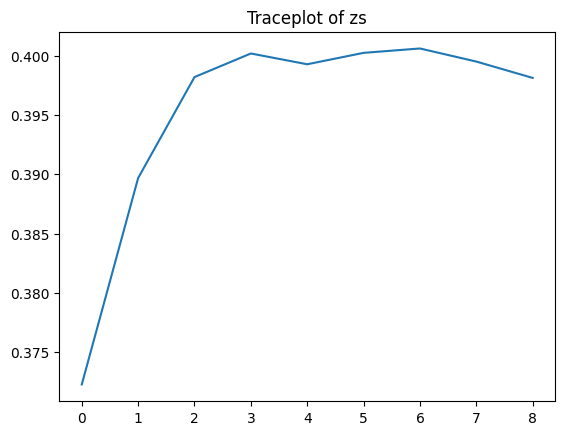

In [181]:
plt.plot(scores)
plt.title("Traceplot of zs")
plt.show()

In [178]:
metrics.adjusted_rand_score(Y_mnist_train, zs[-1])

0.3981219949858653

---
---

# 5 Collapsed Gibbs with Missing Data
Sample $\mathbf{X}_{H}$ missing part in each iteration

In [654]:
def sampleZs(X, zs, nk, nkd1,a_mat, b_mat, α_0, K=10):
    n,D = X.shape

    for i in range(0,n):
        x_i = X[i]
        
        nk[zs[i]] -= 1
        nkd1[zs[i]] -= x_i
        nkd0 = nk[:, None] - nkd1

        log_prior = np.log(α_0 + nk)

        log_like = np.sum(
            betaln(a_mat + nkd1 + x_i, b_mat + nkd0 + 1 - x_i) 
            - betaln(a_mat + nkd1, b_mat + nkd0), axis=1
        )

        cat_dist = np.array(log_prior + log_like)
        cat_dist -= cat_dist.max() # invariance trick

        p = np.exp(cat_dist)
        p /= p.sum()

        cdf = np.cumsum(p)
        u   = rng.random(size=(1))
        zs[i] = (cdf > u).argmax()  # return first index where cdf is greater than random u 

        nk[zs[i]] += 1
        nkd1[zs[i]] += x_i

    return zs

In [655]:
def sampleXs(X, zs, nkd1, nk, a_mat, b_mat, missing_mask, K=10, eps=1e-20):
    n,D = X.shape

    X_sample = X.copy()
    
    for i in range(0,n):
        x = X[i]
        k = zs[i]

        # remove x_i contribution from nkd1, nkd0, nk
        nkd1_i = nkd1[k] - np.nan_to_num(x, nan=0)
        nk_i = nk[k] - 1
        nkd0_i = nk_i - nkd1_i

        # setup binomial distribution to sample
        log_p1 = betaln(a_mat[k] + nkd1_i + 1, b_mat[k] + nkd0_i) # theta if x = ones
        log_p0 = betaln(a_mat[k] + nkd1_i, b_mat[k] + nkd0_i + 1) # theta if x = zeros 

        max_p = np.maximum(log_p1, log_p0)
        p1 = np.exp(log_p1 - max_p)
        p0 = np.exp(log_p0 - max_p)
        p = p1 / (p1 + p0 + eps)

        X_sample[i, missing_mask[i]] = np.random.binomial(1, p[missing_mask[i]])


    return X_sample

In [ ]:
def gibbs_collapsed(X, num_iter, num_burn, K=10, rng=np.random.default_rng(random_seed), eps=1e-20) :
    n, d = X.shape

    missing_mask = np.isnan(X)
    obs_mask = ~missing_mask

    zs_samples = []
    xs_samples = []

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta

    zs = rng.integers(0,K, size=n)

    nk = np.zeros((K))
    nkd1 = np.zeros((K,d))

    # Initialize nk, nkd1
    for k in range(0,K):
        indices = (zs == k)
        obs_k = obs_mask[indices]
        nk[k] = indices.sum()
        nkd1[k] = np.nansum(X[indices] * obs_k, axis=0)

    xs = sampleXs(X, zs, nkd1, nk, a_mat, b_mat, missing_mask)
    
    for t in range(1,num_iter+num_burn):
        # update counts for newly sampled X
        for k in range(0,K):
            indices = (zs == k)
            nk[k] = indices.sum()
            nkd1[k] = xs[indices].sum(axis=0)
            
        zs = sampleZs(xs,zs,nk,nkd1,a_mat,b_mat,α_0)
        xs = sampleXs(X, zs, nkd1, nk, a_mat, b_mat, missing_mask)

        if t > num_burn:
            zs_samples.append(zs.copy())
            xs_samples.append(xs.copy())
    
    return zs_samples, xs_samples

In [652]:
zs,xs= gibbs_collapsed(X_mnist_cover1, 4, 1, 10)

In [653]:
metrics.adjusted_rand_score(Y_mnist_train, zs[-1])

0.22483742987628685